# Pore water quality
Analysis by Emma Kok for the master thesis about peatland rewetting

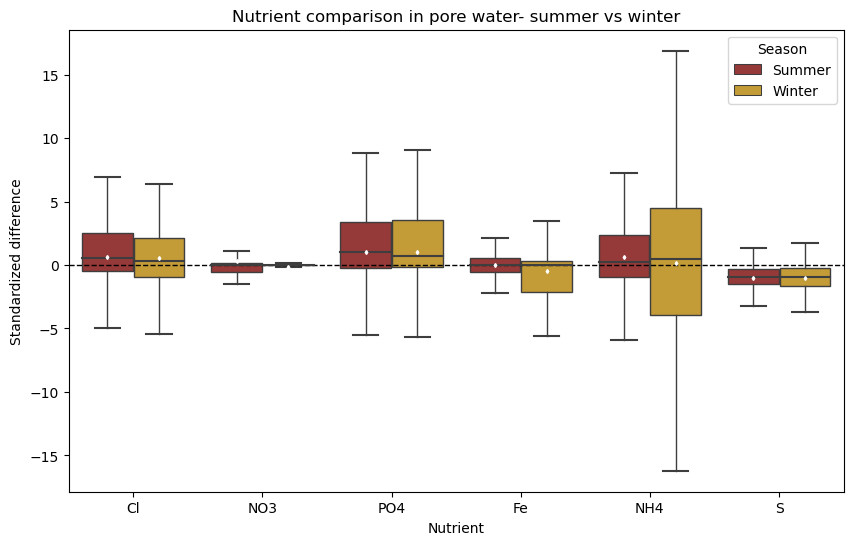

Normality test results for Cl:
  Summer MP data: p-value = 1.0, mean = 6812.955622189626
  Summer RP data: p-value = 1.0, mean = 2742.979436148474
  Winter MP data: p-value = 1.0, mean = 6036.934054562042
  Winter RP data: p-value = 1.0, mean = 2412.3917219096493
Significance test results for Cl:
  Summer data: p-value = 7.178719570331e-55
    Significant difference between summer MP and RP
  Winter data: p-value = 4.2055305580389995e-22
    Significant difference between winter MP and RP

Normality test results for NO3:
  Summer MP data: p-value = 1.0, mean = 25.00662613556953
  Summer RP data: p-value = 1.0, mean = 87.83911604253329
  Winter MP data: p-value = 1.0, mean = 15.559189153439153
  Winter RP data: p-value = 1.0, mean = 79.82239919893192
Significance test results for NO3:
  Summer data: p-value = 2.0382523972238822e-07
    Significant difference between summer MP and RP
  Winter data: p-value = 0.00036486954172238736
    Significant difference between winter MP and RP

Norm

In [2]:
# Import different packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import matplotlib.dates as mdates
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# open data 
NOBV_data = r"C:\Users\Kok30\OneDrive - Waternet Amsterdam\Documents\Analyse_NOBV2\Python_scripts\nat_vs_droog\NOBV_AlleData_B-Ware_WaterChemistry.txt"
df_NOBV = pd.read_csv(NOBV_data, sep='\t')
df_NOBV = df_NOBV.replace(',', '.', regex=True)

# all values are floats, but python does not recognize it, so transfer it all
float_columns = ['PO4', 'P', 'NO3', 'NH4', 'S', 'Fe', 'Cl']
df_NOBV[float_columns] = df_NOBV[float_columns].astype(float)

# make python recognize the dates and set it as index (necessary to combine the data with rain)
df_NOBV['date'] = pd.to_datetime(df_NOBV['date'], format='%d-%m-%Y')
df_NOBV['date'] = df_NOBV['date'].dt.strftime('%d-%m-%y')
df_NOBV = df_NOBV.set_index('date')


def create_df(DF_MP, DF_RP, nutrient):
    DF_MP = DF_MP.reset_index(drop=True)
    DF_RP = DF_RP.reset_index(drop=True)

    df = pd.DataFrame(index=DF_MP.index)  # Use the index from DF_MP

    df['meas'] = DF_MP[nutrient].dropna()
    df['ref'] = DF_RP[nutrient].dropna()

    df['difference'] = df['meas'] - df['ref']
    mean_difference = df['difference'].mean()
    df['standardized diff'] = df['difference'] / abs(mean_difference)
    
    df.sort_index(key=pd.to_datetime, inplace=True)
    return df, df['meas'], df['ref']

# Define the locations to loop through
locations = ['VLIST', 'ALB', 'ASD', 'ZEG'] # 'VLIST', 'ALB', 'ASD', 'ROU', 'ZEG'
fig, ax = plt.subplots(figsize=(10, 6))
data = []  # Empty list to store the data for all locations

for location in locations:
    selected_location = df_NOBV[df_NOBV['location'] == location]

    # Separate summer and winter data
    summer_data = selected_location[(selected_location['month'] >= 5) & (selected_location['month'] <= 9)]
    winter_data = selected_location[(selected_location['month'] >= 10) | (selected_location['month'] <= 4)]

    # Seperate measurement perceel and reference perceel
    pw_sum_MP = summer_data[(summer_data['type'] == 'PW') & (summer_data['treatment'] =='MP')]
    pw_wint_MP = winter_data[(winter_data['type'] == 'PW') & (winter_data['treatment'] == 'MP')]

    pw_sum_RP = summer_data[(summer_data['type'] == 'PW') & (summer_data['treatment'] == 'RP')]
    pw_wint_RP = winter_data[(winter_data['type'] == 'PW') & (winter_data['treatment'] == 'RP')]

    # Summer data
    pw_data_sum = pd.DataFrame()
    for nutrient in ['Cl', 'NO3','PO4', 'Fe', 'NH4', 'S']:
        df, meas, ref = create_df(pw_sum_MP, pw_sum_RP, nutrient)
        df['Nutrient'] = nutrient
        df['Season'] = 'Summer'
        pw_data_sum = pd.concat([pw_data_sum, df])

    # Winter data
    pw_data_wint = pd.DataFrame()
    for nutrient in ['Cl', 'NO3', 'PO4', 'Fe', 'NH4', 'S']:
        df, meas, ref = create_df(pw_wint_MP, pw_wint_RP, nutrient)
        df['Nutrient'] = nutrient
        df['Season'] = "Winter"
        pw_data_wint = pd.concat([pw_data_wint, df])

    # Concatenate summer and winter data
    location_data = pd.concat([pw_data_sum, pw_data_wint])
    location_data['Location'] = location  # Add a column for location
    data.append(location_data)  # Add location data to the list


# Combine data for all locations
all_data = pd.concat(data)

all_data


custom_palette = {"Summer": "brown", "Winter": "goldenrod"}
sns.boxplot(x='Nutrient', y='standardized diff', hue='Season', palette=custom_palette, data=all_data, ax=ax, showmeans=True,
            boxprops=dict(linewidth=1),
            whiskerprops=dict(linewidth=1),
            showfliers=False,
            flierprops=dict(marker='o', markerfacecolor='black', markersize=2),
            meanprops=dict(marker='d', markerfacecolor='white', markeredgecolor='white', markersize=2))  # Updated marker properties

ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax.set_title(f"Nutrient comparison in pore water- summer vs winter")
ax.set_xlabel('Nutrient')
ax.set_ylabel('Standardized difference')
#ax.set_ylim(-40, 40)

plt.savefig("PW_final26_6.pdf")
plt.show()

for nutrient in ['Cl', 'NO3', 'PO4', 'NH4', 'Fe', 'S']:
    # Extract summer and winter data for the nutrient, separated by measurement plot (MP) and reference plot (RP)
    summer_MP_data = all_data[(all_data['Season'] == 'Summer') & (all_data['Nutrient'] == nutrient)]['meas']
    summer_RP_data = all_data[(all_data['Season'] == 'Summer') & (all_data['Nutrient'] == nutrient)]['ref']
    winter_MP_data = all_data[(all_data['Season'] == 'Winter') & (all_data['Nutrient'] == nutrient)]['meas']
    winter_RP_data = all_data[(all_data['Season'] == 'Winter') & (all_data['Nutrient'] == nutrient)]['ref']
    
    # Test normality
    _, summer_MP_p_value = stats.shapiro(summer_MP_data)
    _, summer_RP_p_value = stats.shapiro(summer_RP_data)
    _, winter_MP_p_value = stats.shapiro(winter_MP_data)
    _, winter_RP_p_value = stats.shapiro(winter_RP_data)
    
    # Print normality test results
    print(f"Normality test results for {nutrient}:")
    print(f"  Summer MP data: p-value = {summer_MP_p_value}, mean = {summer_MP_data.mean()}")
    print(f"  Summer RP data: p-value = {summer_RP_p_value}, mean = {summer_RP_data.mean()}")
    print(f"  Winter MP data: p-value = {winter_MP_p_value}, mean = {winter_MP_data.mean()}")
    print(f"  Winter RP data: p-value = {winter_RP_p_value}, mean = {winter_RP_data.mean()}")
    
    # Perform appropriate statistical tests based on normality
    if summer_MP_p_value > 0.05 and summer_RP_p_value > 0.05:
        # If both summer MP and RP data are normally distributed, use paired t-test
        _, summer_p_value = stats.ttest_rel(summer_MP_data.fillna(summer_MP_data.mean()), summer_RP_data.fillna(summer_RP_data.mean()))
        test_used_summer = "Paired t-test"
    else:
        # If either summer MP or RP data is not normally distributed, use Wilcoxon signed-rank test
        _, summer_p_value = stats.wilcoxon(summer_MP_data.fillna(summer_MP_data.mean()), summer_RP_data.fillna(summer_RP_data.mean()))
        test_used_summer = "Wilcoxon signed-rank test"
    
    if winter_MP_p_value > 0.05 and winter_RP_p_value > 0.05:
        # If both winter MP and RP data are normally distributed, use paired t-test
        _, winter_p_value = stats.ttest_rel(winter_MP_data.fillna(winter_MP_data.mean()), winter_RP_data.fillna(winter_RP_data.mean()))
        test_used_winter = "Paired t-test"
    else:
        # If either winter MP or RP data is not normally distributed, use Wilcoxon signed-rank test
        _, winter_p_value = stats.wilcoxon(winter_MP_data.fillna(winter_MP_data.mean()), winter_RP_data.fillna(winter_RP_data.mean()))
        test_used_winter = "Wilcoxon signed-rank test"
    
    # Print test results
    print(f"Significance test results for {nutrient}:")
    print(f"  Summer data: p-value = {summer_p_value}")
    if not pd.isna(summer_p_value) and summer_p_value < 0.05:
        print("    Significant difference between summer MP and RP")
    else:
        print("    No significant difference between summer MP and RP")
    
    print(f"  Winter data: p-value = {winter_p_value}")
    if not pd.isna(winter_p_value) and winter_p_value < 0.05:
        print("    Significant difference between winter MP and RP")
    else:
        print("    No significant difference between winter MP and RP")
    
    print()  

    